### If you're using your own machine, install qiskit first
To do that, uncomment the line below and run cell

In [146]:
# !pip install qiskit

### And check version — should match the one below

In [147]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.1'}

### Let's solve MAXCUT on a simple graph

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j)$

Before going further, let's reformulate it:

$\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$

Therefore the above _maximization_ problem is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

### Constructing the Hamiltonian

MAXCUT is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

We've seen earlier that the Hamiltonian can be constructed by mapping binary variables $s_i$ onto the eigenvalues of $Z$. For the above minimization problem has the following Hamiltonian:

$\sum_{ij\in E}(-Z_iZ_j)$

### Constructing QAOA circuit

Cost Hamiltonian: $C = \sum_{ij\in E}(-Z_iZ_j)$

The full QAOA circuit:

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p C}$ and mixer operator $e^{-i\beta_p B}$

### Let's beging by importing everything we'll need later

In [148]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator

### Consider the following graph

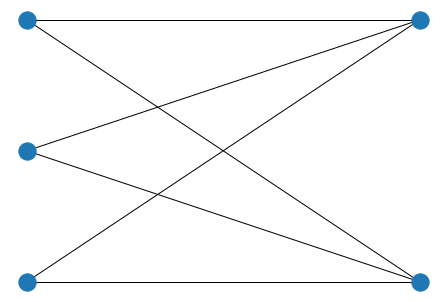

In [149]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

### We can now build the circuit for cost operator

Cost operator $ e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)} = e^{-i\gamma_p Z_0Z_1}e^{-i\gamma_p Z_0Z_2}e^{-i\gamma_p Z_1Z_2}e^{-i\gamma_p Z_1Z_3}e^{-i\gamma_p Z_2Z_3}$

Note that later we will see how to do this more efficiently in Qiskit

In [150]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
    

### Let's verify that our function produces the correct circuit

Cost operator $e^{-i\gamma_p C} = e^{-i\gamma_p Z_0Z_1}e^{-i\gamma_p Z_0Z_2}e^{-i\gamma_p Z_1Z_2}e^{-i\gamma_p Z_1Z_3}e^{-i\gamma_p Z_2Z_3}$

In [151]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

»
q_0: ──■─────────────────■────■──────────────────────────────■─────────────────»
       │                 │    │      ┌───┐    ┌───────────┐  │  ┌───┐     ┌───┐»
q_1: ──┼─────────────────┼────┼──────┤ X ├────┤ RZ(2pi/3) ├──┼──┤ X ├─────┤ X ├»
       │                 │    │      └─┬─┘    └───────────┘  │  └─┬─┘┌───┐└─┬─┘»
q_2: ──┼─────────────────┼────┼────────┼─────────────────────┼────┼──┤ X ├──┼──»
     ┌─┴─┐┌───────────┐┌─┴─┐  │        │                     │    │  └─┬─┘  │  »
q_3: ┤ X ├┤ RZ(2pi/3) ├┤ X ├──┼────────■─────────────────────┼────■────■────┼──»
     └───┘└───────────┘└───┘┌─┴─┐┌───────────┐             ┌─┴─┐            │  »
q_4: ───────────────────────┤ X ├┤ RZ(2pi/3) ├─────────────┤ X ├────────────■──»
                            └───┘└───────────┘             └───┘               »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                   
«q_0: ──────────────────────────────────────────────
«     ┌───────────┐     ┌───┐                       
«q_1: ┤ RZ(2pi/3) ├─────┤ X ├───────────────────────
«     ├───────────┤┌───┐└─┬─┘┌───┐┌───────────┐┌───┐
«q_2: ┤ RZ(2pi/3) ├┤ X ├──┼──┤ X ├┤ RZ(2pi/3) ├┤ X ├
«     └───────────┘└─┬─┘  │  └─┬─┘└───────────┘└─┬─┘
«q_3: ───────────────■────┼────┼─────────────────┼──
«                         │    │                 │  
«q_4: ────────────────────■────■─────────────────■──
«                                                   
«c: 5/══════════════════════════════════════════════
«

### Now we need to build mixer operator

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

In [152]:
def append_x_term(qc, q1, beta):
    qc.h(q1)
    qc.rz(2*beta, q1)
    qc.h(q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


### Let's verify the circuit

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

In [153]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌───┐┌───────────┐┌───┐
q_0: ┤ H ├┤ RZ(2pi/3) ├┤ H ├
     ├───┤├───────────┤├───┤
q_1: ┤ H ├┤ RZ(2pi/3) ├┤ H ├
     ├───┤├───────────┤├───┤
q_2: ┤ H ├┤ RZ(2pi/3) ├┤ H ├
     ├───┤├───────────┤├───┤
q_3: ┤ H ├┤ RZ(2pi/3) ├┤ H ├
     ├───┤├───────────┤├───┤
q_4: ┤ H ├┤ RZ(2pi/3) ├┤ H ├
     └───┘└───────────┘└───┘
c: 5/═══════════════════════

### Now we are ready to build the full circuit

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [154]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

### Let's verify that circuit looks right

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [155]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

┌───┐                                                  ┌───┐┌───────────┐»
q_0: ┤ H ├──■──────────────■────■────────────────────────■──┤ H ├┤ RZ(2pi/3) ├»
     ├───┤  │              │    │    ┌───┐   ┌────────┐  │  ├───┤└───────────┘»
q_1: ┤ H ├──┼──────────────┼────┼────┤ X ├───┤ RZ(pi) ├──┼──┤ X ├─────────────»
     ├───┤  │              │    │    └─┬─┘   └────────┘  │  └─┬─┘    ┌───┐    »
q_2: ┤ H ├──┼──────────────┼────┼──────┼─────────────────┼────┼──────┤ X ├────»
     ├───┤┌─┴─┐┌────────┐┌─┴─┐  │      │                 │    │      └─┬─┘    »
q_3: ┤ H ├┤ X ├┤ RZ(pi) ├┤ X ├──┼──────■─────────────────┼────■────────■──────»
     ├───┤└───┘└────────┘└───┘┌─┴─┐┌────────┐          ┌─┴─┐                  »
q_4: ┤ H ├────────────────────┤ X ├┤ RZ(pi) ├──────────┤ X ├──────────────────»
     └───┘                    └───┘└────────┘          └───┘                  »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌───┐                                                             »
«q_0: ┤ H ├─────────────────────────────────────────────────────────────»
«     ├───┤┌────────┐     ┌───┐┌───┐┌───────────┐    ┌───┐              »
«q_1: ┤ X ├┤ RZ(pi) ├─────┤ X ├┤ H ├┤ RZ(2pi/3) ├────┤ H ├──────────────»
«     └─┬─┘├────────┤┌───┐└─┬─┘├───┤└─┬────────┬┘    └───┘    ┌───┐┌───┐»
«q_2: ──┼──┤ RZ(pi) ├┤ X ├──┼──┤ X ├──┤ RZ(pi) ├──────────────┤ X ├┤ H ├»
«       │  └────────┘└─┬─┘  │  └─┬─┘  └─┬───┬──┘ ┌───────────┐└─┬─┘├───┤»
«q_3: ──┼──────────────■────┼────┼──────┤ H ├────┤ RZ(2pi/3) ├──┼──┤ H ├»
«       │                   │    │      └───┘    └───────────┘  │  ├───┤»
«q_4: ──■───────────────────■────■──────────────────────────────■──┤ H ├»
«                                                                  └───┘»
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                        ░ ┌─┐            
«q_0: ───────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«q_1: ───────────────────░──╫─┤M├─────────
«     ┌───────────┐┌───┐ ░  ║ └╥┘┌─┐      
«q_2: ┤ RZ(2pi/3) ├┤ H ├─░──╫──╫─┤M├──────
«     └───────────┘└───┘ ░  ║  ║ └╥┘┌─┐   
«q_3: ───────────────────░──╫──╫──╫─┤M├───
«     ┌───────────┐┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ┤ RZ(2pi/3) ├┤ H ├─░──╫──╫──╫──╫─┤M├
«     └───────────┘└───┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

### Running a circuit in Qiskit

For the purposes of this tutorial, we will be running the circuits in simulator. To run your circuits on real IBM quantum computers, all you need to do is change the backend. However, the devices are noisy, so there might be dragons!

#### Qiskit qubit ordering

Note that Qiskit uses an ordering where zeroth qubit is the rightmost (the least significant bit in the bistring),
so we need to invert the samples we received

In [156]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

Now we can run the circuit

In [157]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'00000': 38, '10000': 34, '00001': 36, '10001': 23, '01001': 22, '11001': 36, '00101': 34, '10101': 26, '01101': 25, '11101': 33, '00011': 27, '10011': 33, '01011': 31, '11011': 36, '00111': 30, '10111': 33, '01111': 34, '11111': 24, '01000': 39, '11000': 29, '00100': 27, '10100': 37, '01100': 36, '11100': 31, '00010': 29, '10010': 29, '01010': 35, '11010': 28, '00110': 44, '10110': 40, '01110': 30, '11110': 35}


### How good were these results?

To answer that, we need to compute $<\psi|C|\psi>$. Luckily, C is a classical Hamiltonian, so we can do this easily. We are going to compute -1 times the value of the cut because by convention classical optimizers minimize (this will come up shortly).

In [158]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

### Estimate energy from the sample

In [159]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.9814453125

### Putting all the pieces together

As you remember, QAOA is a variational algorithm, so we will need a classical optimizer to optimize variational parameters. We will use Constrained Optimization BY Linear Approximation (COBYLA) from `scipy.optimize`.

We need to wrap our circuit into a black-box objective function `f` that COBYLA could optimize. Note that by convention all optimizers perform _minimization_, so we had to put a minus sign in front of our objective earlier.

In [185]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

### Now we can run the optimizer to get optimal parameters!

In [186]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 1000
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':1000, 'disp': True})
res_sample

     fun: -5.2978515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 134
  status: 1
 success: True
       x: array([1.83749394, 2.1345936 , 1.9319531 , 2.09862998, 0.347631  ,
       2.04618358, 6.11249139, 2.31785137, 3.56479392, 5.87260613])

### To get the solution strings, let's run the circuit with optimal parameters

In [187]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

{'10000': 5,
 '00001': 30,
 '10001': 1,
 '01001': 1,
 '00101': 1,
 '01101': 2,
 '11101': 25,
 '00011': 387,
 '10011': 16,
 '01011': 20,
 '11011': 1,
 '00111': 27,
 '10111': 2,
 '01111': 4,
 '01000': 1,
 '11000': 24,
 '00100': 3,
 '10100': 18,
 '01100': 29,
 '11100': 370,
 '00010': 33,
 '01010': 1,
 '11010': 2,
 '00110': 1,
 '01110': 1,
 '11110': 19}

### How good are there results?

<BarContainer object of 4 artists>

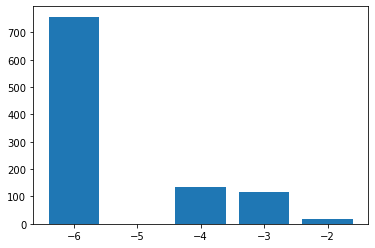

In [188]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

Pretty good! Most of the results we get correspond to good solutions!

Best string: 00011 with cut: 6


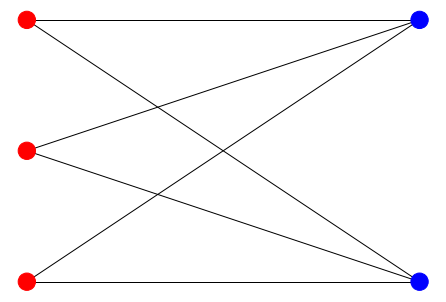

In [189]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### Using statevector simulator

What if you want to get the full QAOA state? Luckily, Qiskit provides `statevector_simulator` backend. 

### What is a state vector?

State vector is a vector of amplitudes, e.g.: $\frac{1}{\sqrt{2}}\bigg(|00\rangle + |11\rangle\bigg) \rightarrow (\frac{1}{\sqrt{2}}, 0, 0, \frac{1}{\sqrt{2}})$

In [190]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
sv = execute(qc, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
sv

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Less luckily, qubit ordering considerations still apply. Below are some helper functions we're going to use.

In [191]:
# Endianness conversion tools from https://github.com/Qiskit/qiskit-terra/issues/1148#issuecomment-438574708

import numpy as np

def state_num2str(basis_state_as_num, nqubits):
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
         adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

### Running using full-state (`statevector`) simulator

Note that a few things are different when using the full statevector simulator. First, we must not measure. Second, as the result, we get amplitudes instead of samples.

In [192]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
    return qc

Second, we need to get which amplitudes correspond to which computational basis states (= binary strings)

In [193]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts


Let's try plugging in the optimal parameters we found using the QASM simulator

In [194]:
backend = Aer.get_backend('statevector_simulator')
qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
state_to_ampl_counts(sv)

{'00000': (0.0023184716167343636-0.018265551579417366j),
 '00001': (-0.15087799951290576-0.06435307927950312j),
 '00010': (-0.1508779995129056-0.06435307927950315j),
 '00011': (-0.5039281708659944+0.33267792595922163j),
 '00100': (0.03342522858967127+0.042212225074949566j),
 '00101': (0.010379182964348156+0.03628151787356761j),
 '00110': (0.010379182964348286+0.03628151787356787j),
 '00111': (0.14504104193207745-0.01712007050961606j),
 '01000': (0.03342522858967136+0.04221222507494954j),
 '01001': (0.010379182964348263+0.036281517873567676j),
 '01010': (0.010379182964348258+0.036281517873567745j),
 '01011': (0.14504104193207756-0.0171200705096159j),
 '01100': (0.14504104193207762-0.017120070509616364j),
 '01101': (0.010379182964348286+0.03628151787356744j),
 '01110': (0.010379182964348166+0.036281517873567676j),
 '01111': (0.033425228589671396+0.042212225074949615j),
 '10000': (0.03342522858967134+0.04221222507494943j),
 '10001': (0.010379182964348149+0.03628151787356766j),
 '10010': (

### Let's verify that we get the same energy

In [195]:
def compute_maxcut_energy_sv(sv, G):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    counts = state_to_ampl_counts(sv)
    return sum(maxcut_obj(np.array([int(x) for x in k]), G) * (np.abs(v)**2) for k, v in counts.items())

compute_maxcut_energy_sv(sv, G)

-5.296260485608109

Yay! Energy matches

### Now, we can run the full optimization loop with the statevector simulator

In [196]:
def get_black_box_objective_sv(G,p):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G,beta, gamma)
        sv = execute(qc, backend).result().get_statevector()
        # return the energy
        return compute_maxcut_energy_sv(get_adjusted_state(sv), G)
    return f

Copying and pasting the code for the `qasm_simulator`...

In [197]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 1000
res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':1000, 'disp': True})
res_sv

     fun: -5.929352734736993
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([2.06992666, 2.11149191, 1.98695059, 1.87497117, 0.5041377 ,
       2.31051888, 6.11494423, 2.32616341, 3.69567318, 6.0685535 ])

We get **much better solution**!

In [200]:
res_sample['fun'], res_sv['fun']

(-5.2978515625, -5.929352734736993)

The lesson here is that our simple deterministic optimizers (like COBYLA) assume that *every function value they get is true*. We have to bake the assumption of stochaisticity into the optimizers we use!

### That was pretty involved! Is there an easier way?

So far we have effectively reimplemented the entire stack of tools used in Qiskit. Wasn't too bad, huh? Note that you can fairly easily do the above in any framework you prefer (Google cirq, Rigetti PyQuil, ...), all you need to learn is how to apply gates. What follows is more specific to IBM Qiskit (though not entirely).

Luckily, you don't have to reimplement QAOA every time you want to use it (though I do recommend doing it at least once to understand what's going on!)

Qiskit provides a number of tools for optimization, some as simple to use as plugging your graph into a declarative interface. Today we're going to look at some of them. I have copied and pasted some of the code from Qiskit here for educational purposes.

### Recap

To solve MAXCUT we had to do the following:

1. Choose a problem class (maxcut) and a problem instance (graph)
2. Come up with a general Hamiltonian for the problem class
3. Build specific Hamiltonian for the problem instance
4. From the Hamiltonian, construct QAOA circuit
5. Wrap QAOA circuit in a black box function
6. Optimize QAOA parameters
7. Get solution by running QAOA circuit with optimal parameters

### Qiskit to help!

Let's see how Qiskit can help us with steps 3 and 4:


1. Choose a problem class (maxcut) and a problem instance (graph)
2. Come up with a general Hamiltonian for the problem class
3. **Build specific Hamiltonian for the problem instance**
4. **From the Hamiltonian, construct QAOA circuit**
5. Wrap QAOA circuit in a black box function
6. Optimize QAOA parameters
7. Get solution by running QAOA circuit with optimal parameters

### Building the circuit in Qiskit

First thing we're going to try is to use Qiskit tools to build circuit instead of building it by hand. To do that, we will have to construct a Hamiltonian object and pass it to QAOA class initializer.

### Building the Hamiltonian in Qiskit

Qiskit uses weird notation that we will not get into

In [19]:
# copied from qiskit.optimization.ising.max_cut

def get_cost_operator(weight_matrix):
    """Generate Hamiltonian for the max-cut problem of a graph.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        WeightedPauliOperator: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    num_nodes = weight_matrix.shape[0]
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=np.bool)
                z_p = np.zeros(num_nodes, dtype=np.bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([0.5 * weight_matrix[i, j], Pauli(z_p, x_p)])
                shift -= 0.5 * weight_matrix[i, j]
    return WeightedPauliOperator(paulis=pauli_list), shift

### First, let's construct a Hamiltonian 

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$. Qiskit conveniently takes care of the constant in form of offset.

Corresponding Hamiltonian is $\frac{1}{2}\sum_{ij\in E}(-Z_iZ_j)$, but Qiskit by convention always searches for the _ground_ state, so the sign is flipped.

In [20]:
C, offset = get_cost_operator(w)
print(C.print_details())

IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIZI	(0.5+0j)
ZZII	(0.5+0j)



Looks correct!

### Verifying that Hamiltonian is correct

Recall that since "Hamiltonian" is just a fancy word for matrix*, we can find its ground state (lowest eigenvalue eigenvector) classically with any eigensolver. We can use Qiskit `ExactEigensolver`, which in is just a wrapper around `np.linalg.eig` and `scisparse.linalg.eigs`:

```python
class ExactEigensolver(ClassicalAlgorithm):
    """The Exact Eigensolver algorithm."""
    <...>
    def _solve(self):
        if self._operator.dia_matrix is None:
            if self._k >= self._operator.matrix.shape[0] - 1:
                logger.debug("Scipy doesn't support to get all eigenvalues, using numpy instead.")
                eigval, eigvec = np.linalg.eig(self._operator.matrix.toarray())
            else:
                eigval, eigvec = scisparse.linalg.eigs(self._operator.matrix, k=self._k, which='SR')
    <...>
```
(code from https://github.com/Qiskit/qiskit-aqua/blob/0.6.2/qiskit/aqua/algorithms/classical/exact_eigen_solver/exact_eigen_solver.py)

*not really

### Let's run ExactEigensolver on our Hamiltonian (Hermitian matrix)

In [23]:
ee = NumPyEigensolver(C, k=1) # k=1 means lowest eigenvalue and eigenvector

result = ee.run()
result

{'eigenvalues': array([-1.5+0.j]), 'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)}

### Now, we need to convert the eigenvectors of $2^n\times 2^n$ matrix into solutions to our MAXCUT problem (vectors of size $n$)

Luckily, Qiskit has a function for that!

In [27]:
from qiskit.optimization.applications.ising.common import sample_most_likely
print(f"Solution: {sample_most_likely(result['eigenstates'][0])} with cut: {result['eigenvalues']+offset}")


Solution: [0 1 1 0] with cut: [-4.+0.j]


And it's a correct solution. So we've built our Hamiltonian correctly. Note that you can use the same process (building a Hamiltonian, running ExactEigensolver on it) in prototyping your own algorithms.

### Q: Can I build my Hamiltonian as a matrix?

Yes you can! Let's try doing it it for the same four-node graph:

$C=\frac{1}{2}\sum_{ij\in E}Z_iZ_i = \frac{1}{2}(Z\otimes Z \otimes I \otimes I + Z\otimes I \otimes Z \otimes I + I\otimes Z \otimes Z \otimes I + I\otimes Z \otimes I \otimes Z + I\otimes I \otimes Z \otimes Z)$

In [28]:
I = np.eye(2,2)
Z = np.array([[1.,0.], [0.,-1.]])

Z0Z1 = np.kron(np.kron(np.kron(Z,Z), I), I)
Z0Z2 = np.kron(np.kron(np.kron(Z,I), Z), I)
Z1Z2 = np.kron(np.kron(np.kron(I,Z), Z), I)
Z1Z3 = np.kron(np.kron(np.kron(I,Z), I), Z)
Z2Z3 = np.kron(np.kron(np.kron(I,I), Z), Z)

C_numpy = 0.5 * (Z0Z1 + Z0Z2 + Z1Z2 + Z1Z3 + Z2Z3)

PS If you know a better way of doing this -- please let me know!

### Let's check that the Hamiltonian we've built is correct

No shenanigans here -- just numpy.

In [29]:
# Get eigenvalues and eigenvectors
eigval, eigvec = np.linalg.eig(C_numpy)
# Sort eigenvalues
idx = eigval.argsort()
# Get lowest
lowest_eigval = eigval[idx][0]
lowest_eigvec = eigvec[idx][0]
# Only need qiskit to convert eigenvector into the solution to our problem
print(f"Solution: {sample_most_likely(lowest_eigvec)} with cut: {lowest_eigval+offset}")

Solution: [0. 1. 1. 0.] with cut: -4.0


And this is correct!

### Constructing QAOA circuit for our Hamiltonian

Qiskit provides a class that constructs QAOA circuit for us from a Hamiltonian. 

The abstraction Qiskit uses for this is "Variational Form". Roughly speaking, variational form is just a parameterized circuit that prepares some parameterized state $\psi(\theta)$. For QAOA, as you might recall, this parameterized state is:

$$  \begin{aligned} 
    |\psi{(\mathbb{\theta})}> & = |\psi{(\mathbb{\beta},\mathbb{\gamma})}>\\
    &=  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>.
  \end{aligned} $$

In [34]:
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm

p = 4
var_form = QAOAVarForm(C.to_opflow(), p)

### Constructing QAOA circuit for our Hamiltonian (cont'd)

To construct circuit, we need to pass the parameters $\mathbb{\beta}, \mathbb{\gamma}$ to the variational form.

In [35]:
N = G.number_of_nodes()

# Lower and upper bounds: beta \in {0, pi}, gamma \in {0, 2*pi}
lb = np.zeros(2*p)
ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
random_point = np.random.uniform(lb, ub, 2*p)

# Build the circuit
qc = var_form.construct_circuit(random_point)

# Don't forget to measure! This requires a little hack
if not qc.cregs:
    c = ClassicalRegister(N, name='c')
    qc.add_register(c)
qc.measure(qc.qregs[0], qc.cregs[0])
# And run
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend).result().get_counts()
print(counts)


{'0000': 232, '0001': 31, '0010': 16, '0011': 73, '0100': 10, '0101': 73, '0110': 34, '0111': 46, '1000': 26, '1001': 32, '1010': 84, '1011': 14, '1100': 73, '1101': 13, '1110': 27, '1111': 240}


### Let's compare Qiskit circuit with the one we constructed earlier

Note that Qiskit uses Hamiltonian $C = \frac{1}{2}\sum_{ij\in E}(-Z_iZ_j)$, so we will have to add a factor of $\frac{1}{2}$ to our parameters gamma to match our circuit

In [36]:
qc_our = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc_our.draw()

┌───┐                                        ┌───┐┌───────────┐┌───┐     »
q_0: ┤ H ├──■──────────────■────■──────────────■──┤ H ├┤ RZ(2pi/3) ├┤ H ├─────»
     ├───┤┌─┴─┐┌────────┐┌─┴─┐  │              │  └───┘└───────────┘└───┘     »
q_1: ┤ H ├┤ X ├┤ RZ(pi) ├┤ X ├──┼──────────────┼────■─────────────────■────■──»
     ├───┤└───┘└────────┘└───┘┌─┴─┐┌────────┐┌─┴─┐┌─┴─┐  ┌────────┐ ┌─┴─┐  │  »
q_2: ┤ H ├────────────────────┤ X ├┤ RZ(pi) ├┤ X ├┤ X ├──┤ RZ(pi) ├─┤ X ├──┼──»
     ├───┤                    └───┘└────────┘└───┘└───┘  └────────┘ └───┘┌─┴─┐»
q_3: ┤ H ├───────────────────────────────────────────────────────────────┤ X ├»
     └───┘                                                               └───┘»
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                                   ░ ┌─┐      »
«q_0: ──────────────────────────────────────────────────────────────░─┤M├──────»
«                    ┌───┐┌───────────┐┌───┐                        ░ └╥┘┌─┐   »
«q_1: ────────────■──┤ H ├┤ RZ(2pi/3) ├┤ H ├────────────────────────░──╫─┤M├───»
«                 │  └───┘└───────────┘└───┘┌───┐┌───────────┐┌───┐ ░  ║ └╥┘┌─┐»
«q_2: ────────────┼────■─────────────────■──┤ H ├┤ RZ(2pi/3) ├┤ H ├─░──╫──╫─┤M├»
«     ┌────────┐┌─┴─┐┌─┴─┐  ┌────────┐ ┌─┴─┐├───┤├───────────┤├───┤ ░  ║  ║ └╥┘»
«q_3: ┤ RZ(pi) ├┤ X ├┤ X ├──┤ RZ(pi) ├─┤ X ├┤ H ├┤ RZ(2pi/3) ├┤ H ├─░──╫──╫──╫─»
«     └────────┘└───┘└───┘  └────────┘ └───┘└───┘└───────────┘└───┘ ░  ║  ║  ║ »
«c: 4/═════════════════════════════════════════════════════════════════╩══╩══╩═»
«                                                                      0  1  2 »
«        
«q_0: ───
«        
«q_1: ───
«        
«q_2: ───
«     ┌─┐
«q_3: ┤M├
«     └╥┘
«c: 4/═╩═
«      3

In [37]:
from qiskit.compiler import transpile
var_form_qiskit = QAOAVarForm(C.to_opflow(), 1)
qc_qiskit = var_form_qiskit.construct_circuit([np.pi/3, np.pi])
circuit_qiskit = transpile(qc_qiskit, optimization_level=0,basis_gates=['u1', 'u2', 'u3', 'cx'])
circuit_qiskit.draw()

┌──────────┐                                            »
q_0: ┤ U2(0,pi) ├────────────────────────────────────────────»
     ├──────────┤                      ┌───┐┌──────────┐┌───┐»
q_1: ┤ U2(0,pi) ├──────────────────────┤ X ├┤ U1(pi/6) ├┤ X ├»
     ├──────────┤┌───┐┌──────────┐┌───┐└─┬─┘└──────────┘└─┬─┘»
q_2: ┤ U2(0,pi) ├┤ X ├┤ U1(pi/6) ├┤ X ├──┼────────────────┼──»
     ├──────────┤└─┬─┘└──────────┘└─┬─┘  │                │  »
q_3: ┤ U2(0,pi) ├──■────────────────■────■────────────────■──»
     └──────────┘                                            »
«                                           ┌───┐┌──────────┐┌───┐»
«q_0: ──────────────────────────────────────┤ X ├┤ U1(pi/6) ├┤ X ├»
«             ┌───┐        ┌──────────┐┌───┐└─┬─┘└──────────┘└─┬─┘»
«q_1: ────────┤ X ├────────┤ U1(pi/6) ├┤ X ├──┼────────────────┼──»
«             └─┬─┘        └──────────┘└─┬─┘  │                │  »
«q_2: ──────────■────────────────────────■────■────────────────■──»
«     ┌───────────────────┐                                       »
«q_3: ┤ U3(pi,-pi/2,pi/2) ├───────────────────────────────────────»
«     └───────────────────┘                                       »
«             ┌───┐        ┌──────────┐┌───┐┌───────────────────┐
«q_0: ────────┤ X ├────────┤ U1(pi/6) ├┤ X ├┤ U3(pi,-pi/2,pi/2) ├
«             └─┬─┘        └──────────┘└─┬─┘├───────────────────┤
«q_1: ──────────■────────────────────────■──┤ U3(pi,-pi/2,pi/2) ├
«     ┌───────────────────┐                 └───────────────────┘
«q_2: ┤ U3(pi,-pi/2,pi/2) ├──────────────────────────────────────
«     └───────────────────┘                                      
«q_3: ───────────────────────────────────────────────────────────
«

In [37]:
# TODO: qubit ordering! confirm that they produce the same unitary!

### Yay! The two match

Note that RZ(x) = U1(x) and H = U2(0,pi)

### Q: what if I want to use the Hamiltonian that I've built in numpy?

You can do that too! All you need to do is to convert it to Qiskit object

In [39]:
print(f"type of C_numpy is {type(C_numpy)}")

from qiskit.aqua.operators import MatrixOperator
C_converted = MatrixOperator(C_numpy)

# Now we can use it!
var_form = QAOAVarForm(C_converted.to_opflow(), p)
var_form

type of C_numpy is <class 'numpy.ndarray'>


### Q: Okay, but we still have to wrap it into objective and pass it to optimizer, which is a lot of work! Can Qiskit do that for me too?

Yes! The reason I'm leaving it to the end of the tutorial is that it looks nice and clean, but it might not be flexible enough for a researcher like yourself. Moreover, the cleanliness of the interface hides a lot of underlying complexity (as you've seen earlier) and introduces some limitations. One of such limitations is that you have to work with optimizers supported by Qiskit (though it's fairly easy to add a new one). The main point is that qiskit is open source, so you can always modify it to suit your needs! 

In [44]:
from qiskit.aqua.algorithms.minimum_eigen_solvers import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.applications.ising import max_cut

cobyla = COBYLA(maxiter=1000)
qaoa = QAOA(C_converted, cobyla, p=4)
backend = Aer.get_backend('qasm_simulator')
result = qaoa.run(backend)

x = sample_most_likely(result['eigenstate'])
print('final maxcut energy:', result['eigenvalue'] + offset)
print('solution:', x)
print('solution objective:', max_cut.max_cut_value(x, w))

Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.
Evolved Hamiltonian is not composed of only MatrixOps, converting to Matrix representation, which can be expensive.


final maxcut energy: (-3.5302734375+0j)
solution: [0 1 1 0]
solution objective: 4
